Clean road network to reduce number of nodes and links

## Imports

In [1]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import pandas as pd
import re
import xml.etree.ElementTree as ET

sys.path.append('../../')
from mnms.io.graph import load_graph, save_graph
from mnms.graph.road import RoadDescriptor
from mnms.graph.layers import MultiLayerGraph
from mnms.generation.layers import generate_layer_from_roads
from mnms.generation.zones import generate_one_zone
from mnms.tools.render import draw_roads, draw_line, draw_odlayer
from mnms.vehicles.veh_type import Car

## Parameters

In [2]:
### Parameters

# Files and directories
current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
file_road_network = indir + 'new_network.json' # mlgraph with the road network only
file_road_network_lite = indir + 'new_network_lite.json' # mlgraph with simplified road network

In [3]:
### Get the MLGraph without TCs 
amsterdam_graph = load_graph(file_road_network)
roads = amsterdam_graph.roads

In [4]:
x_nodes = []
y_nodes = []
for key in roads.nodes.keys():
    pos = roads.nodes[key].position
    x_nodes.append(pos[0])
    y_nodes.append(pos[1])

## Visualization

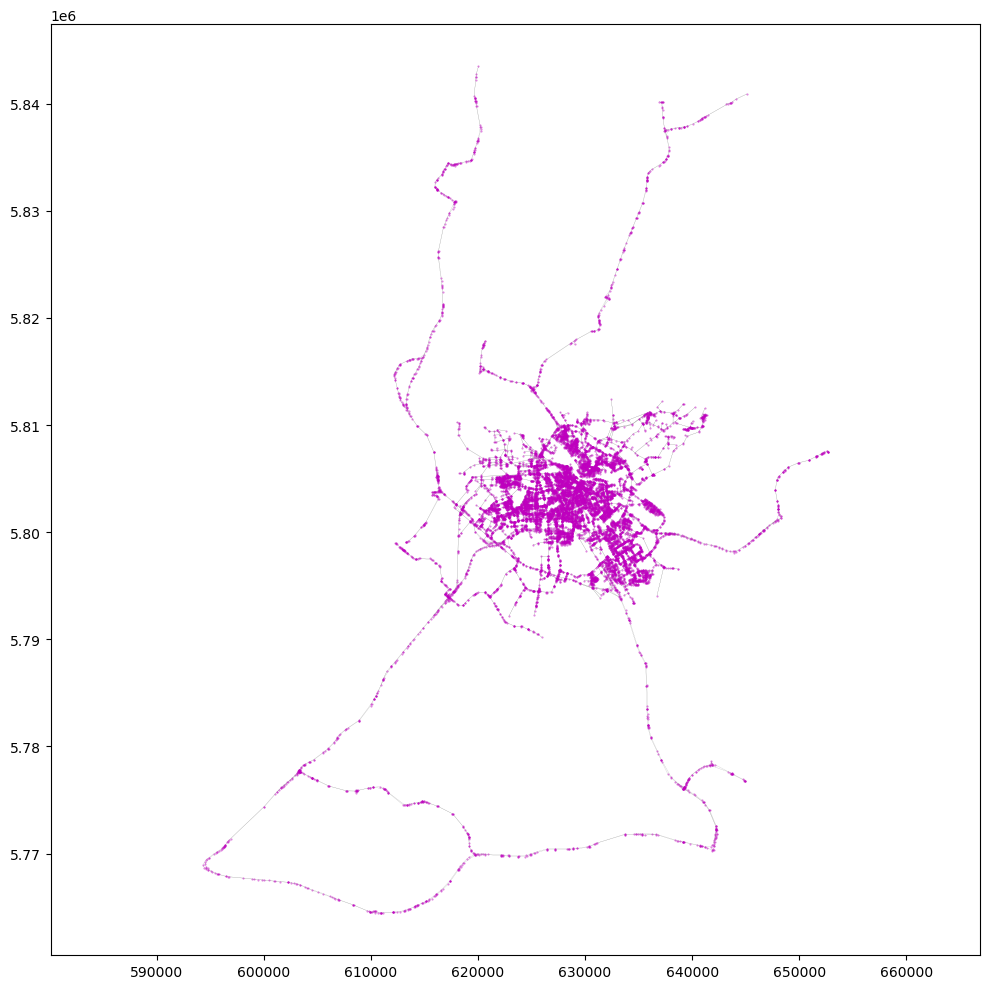

In [5]:
### Visualize the roads
fig, ax = plt.subplots(figsize=(10, 10))
draw_roads(ax, roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

In [6]:
print(len(roads.nodes), len(roads.sections))

17435 31177


In [7]:
#roads.sections

In [8]:
#roads.sections.keys()

In [9]:
print(roads.sections['m132486921_0_r'])
print(roads.sections['m132486921_0'])

RoadSection(id='m132486921_0_r', upstream='m3907020113', downstream='m3907020112', length=85.68202791763846, zone='RES')
RoadSection(id='m132486921_0', upstream='m3907020112', downstream='m3907020113', length=85.68202791763846, zone='RES')


In [10]:
nodes_id = roads.nodes.keys()

In [11]:
df_sections = pd.DataFrame.from_dict(roads.sections, orient='index')
df_nodes = pd.DataFrame.from_dict(roads.nodes, orient='index')
df_nodes['x'] = df_nodes.position.apply(lambda p : p[0])
df_nodes['y'] = df_nodes.position.apply(lambda p : p[1])

In [12]:
# Remove looped sections
df_sections = df_sections[df_sections.downstream != df_sections.upstream]

(0.0, 200.0)

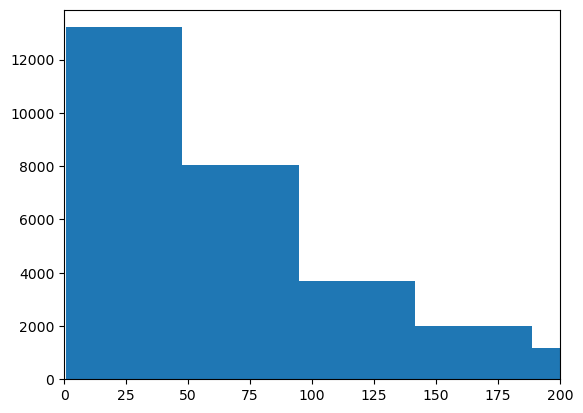

In [13]:
plt.hist(df_sections.length.values, bins=100)
plt.xlim([0,200])

In [14]:
nodes_to_keep = []
sections_to_keep = []
nb_empty = 0
nb_remove = 0

for n_id in list(nodes_id):
    links_entry = df_sections[df_sections.downstream==n_id]
    links_exit = df_sections[df_sections.upstream==n_id]
    empty = (len(links_entry)==0 and len(links_exit)==0)
    remove1 = (len(links_entry)==1 and len(links_exit)==1) and (set(links_entry.upstream.values) != set(links_exit.downstream.values))
    remove2 = (len(links_entry)==2 and len(links_exit)==2) and (set(links_entry.upstream.values) == set(links_exit.downstream.values)) and (len(set(links_entry.upstream.values))==2)
    if empty:
        nb_empty += 1
    elif remove1:
        n_up = links_entry.iloc[0].upstream
        n_down = links_exit.iloc[0].downstream
        if n_up==n_down:
            break
        id = n_up + '_' + n_down
        length = links_exit.iloc[0].length + links_entry.iloc[0].length
        # Remove link exit
        df_sections.drop(links_exit.iloc[0].id, inplace=True)
        # Replace link down
        df_sections.loc[links_entry.iloc[0].id, 'id'] = id
        df_sections.loc[links_entry.iloc[0].id, 'downstream'] = n_down
        df_sections.loc[links_entry.iloc[0].id, 'upstream'] = n_up
        df_sections.loc[links_entry.iloc[0].id, 'length'] = length
        df_sections.rename(index={links_entry.iloc[0].id:id},inplace=True)
        nb_remove += 1
    elif remove2: 
        n_link = len(links_entry)
        for i_l in range(n_link):
            n_up = links_entry.upstream.values[i_l]
            n_down = links_entry.upstream.values[n_link-i_l-1]
            if n_up==n_down:
                break
            id = n_up + '_' + n_down
            length = links_exit.iloc[i_l].length + links_entry.iloc[n_link-i_l-1].length
            # Remove link exit
            df_sections.drop(links_exit.iloc[i_l].id, inplace=True)
            # Replace link down
            df_sections.loc[links_entry.iloc[i_l].id, 'id'] = id
            df_sections.loc[links_entry.iloc[i_l].id, 'downstream'] = n_down
            df_sections.loc[links_entry.iloc[i_l].id, 'upstream'] = n_up
            df_sections.loc[links_entry.iloc[i_l].id, 'length'] = length
            df_sections.rename(index={links_entry.iloc[i_l].id:id},inplace=True)
            nb_remove += 1
    else:
        nodes_to_keep.append(n_id)
print(nb_empty, nb_remove)


KeyboardInterrupt: 

In [ ]:
links_entry

In [ ]:
df_sections

In [ ]:
df_sections[df_sections.upstream=='m46179587']

In [ ]:
simplified_roads = RoadDescriptor()
for n_id in nodes_to_keep:
    position = df_nodes.position[n_id]
    simplified_roads.register_node(n_id, position)

for sec, rsect in df_sections.iterrows():
    simplified_roads.register_section(sec, rsect.upstream, rsect.downstream, rsect.length)

simplified_roads.add_zone(generate_one_zone('RES',simplified_roads))

In [ ]:
x_nodes2 = []
y_nodes2 = []
id_nodes2 = []
for key in simplified_roads.nodes.keys():
    pos = simplified_roads.nodes[key].position
    x_nodes2.append(pos[0])
    y_nodes2.append(pos[1])
    id_nodes2.append(simplified_roads.nodes[key].id)

In [ ]:
#df_nodes[(df_nodes.x>620000) & (df_nodes.x<620200) & (df_nodes.y>5.8e6+200) & (df_nodes.y<5.8e6+350)]

In [ ]:
n_id = 'm1612084863'
print(df_sections[df_sections.downstream==n_id])
print(df_sections[df_sections.upstream==n_id])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
draw_roads(ax, roads, color='black', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
draw_roads(ax, simplified_roads, color='red', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
plt.plot(x_nodes, y_nodes, '.m', alpha=0.5)#, markersize=1)
plt.plot(x_nodes2, y_nodes2, '.g', alpha=0.5)#, markersize=1)
#plt.xlim([620000, 621000])
#plt.ylim([5.80e6, 5.8002e6])

In [ ]:
print(len(simplified_roads.nodes), len(simplified_roads.sections))

In [ ]:
layer_car = generate_layer_from_roads(roads = simplified_roads,
                              layer_id = amsterdam_graph.layers['CAR'].id,
                              #class_layer = SimpleLayer,
                              veh_type = Car,
                              default_speed = amsterdam_graph.layers['CAR'].default_speed)
new_graph = MultiLayerGraph([layer_car])


In [ ]:
# Save graph
#save_graph(new_graph, file_road_network_lite)